<a href="https://colab.research.google.com/github/ReginaMT/ReginaMT/blob/main/espectros2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn scikeras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from scikeras.wrappers import KerasClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
import sklearn, scikeras
print("scikit-learn:", sklearn.__version__)
print("scikeras:", scikeras.__version__)



TensorFlow: 2.19.0
scikit-learn: 1.7.2
scikeras: 0.13.0


In [2]:
#cargar datoss
df_spectra = pd.read_csv('/content/balanced_spectra_features.csv')
print("CSV columns:", df_spectra.columns.tolist())
display(df_spectra.tail())

filepath = '/content/balanced_spectra_flux.npz'
data = np.load(filepath, allow_pickle=True)
targetids = data['targetids']
flux_arrays = data['flux_arrays']

print(f"Loaded {len(targetids)} spectra from {filepath}")
print("flux_arrays shape:", flux_arrays.shape)


CSV columns: ['targetid', 'survey', 'program', 'desi_target', 'z', 'zwarn', 'spectype', 'desiname', 'specid', 'redshift']


,targetid,survey,program,desi_target,z,zwarn,spectype,desiname,specid,redshift
487,39628031613995781,main,dark,4611686018427650052,1.132489,0,GALAXY,DESI J020.5016+10.2330,3.962803e+16,1.132489
488,39627689362983081,main,dark,4611686018428829830,0.870082,0,GALAXY,DESI J073.9506-03.9645,3.962769e+16,0.870082
489,39627474228742564,main,dark,4611686018428829830,1.057718,0,GALAXY,DESI J065.4778-12.9870,3.962747e+16,1.057718
490,39627812356756299,main,dark,4611686018427650052,1.293974,0,QSO,DESI J206.9822+01.0158,3.962781e+16,1.293974
491,39627869730643820,main,dark,6917529027641344004,0.777878,0,QSO,DESI J027.2577+03.5412,3.962787e+16,0.777878


Loaded 492 spectra from /content/balanced_spectra_flux.npz
flux_arrays shape: (492, 7781)


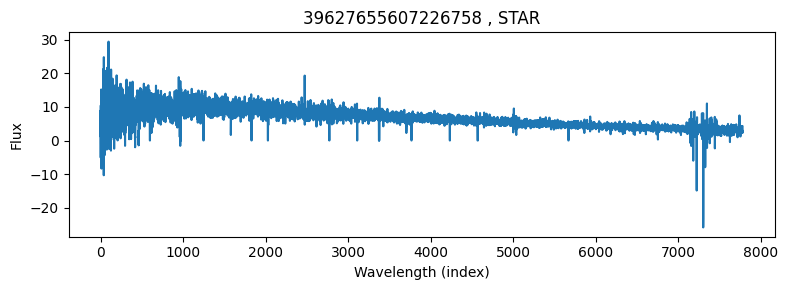

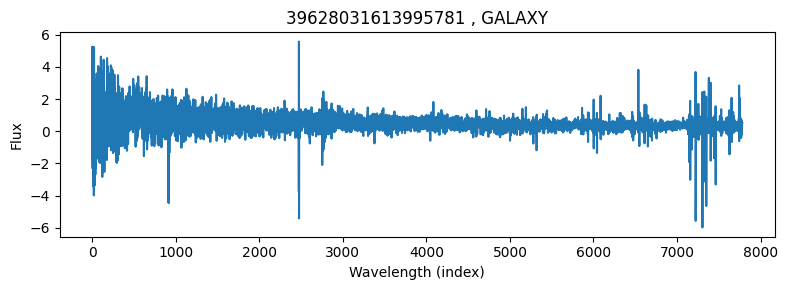

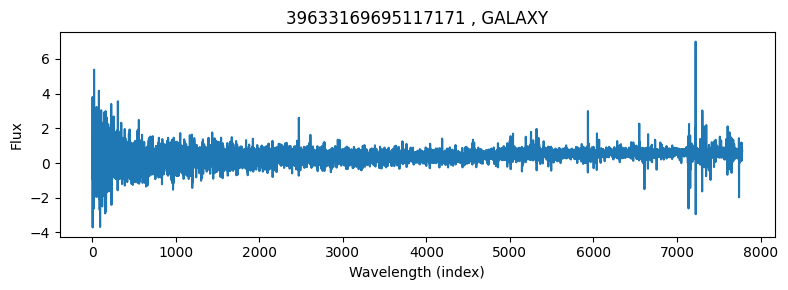

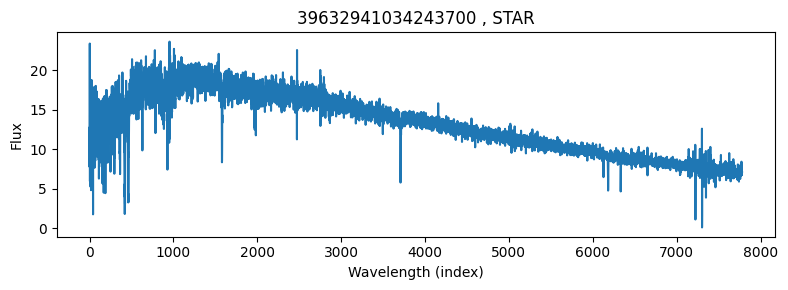

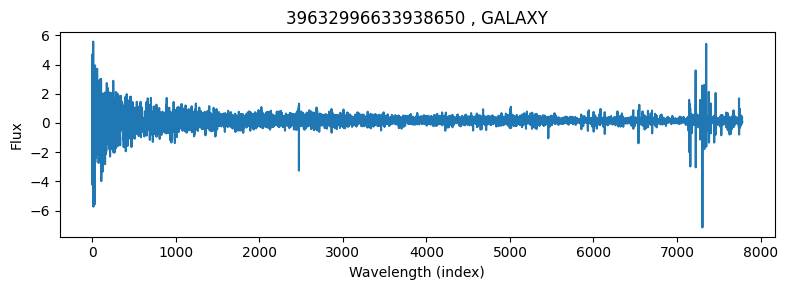

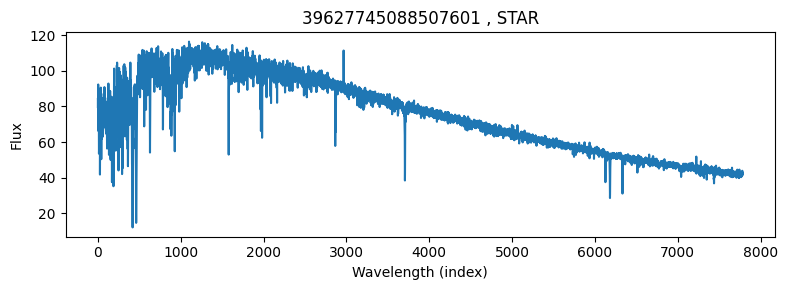

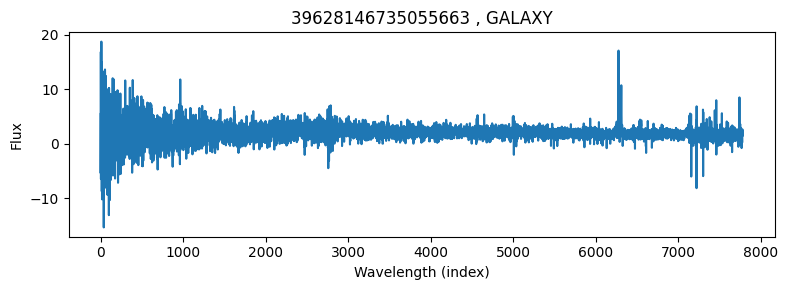

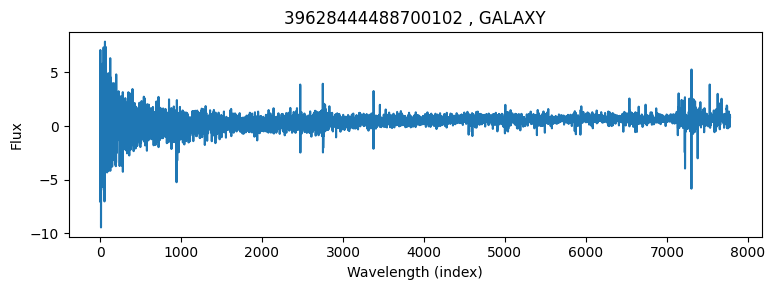

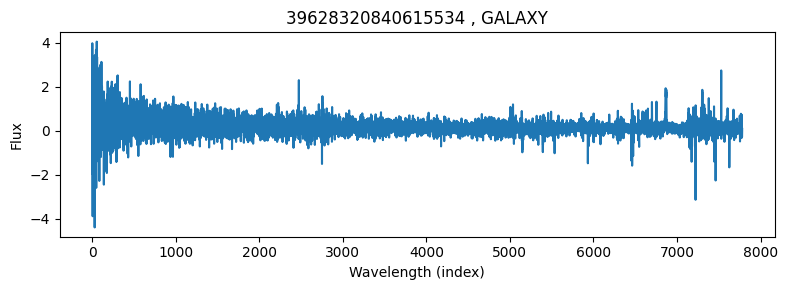

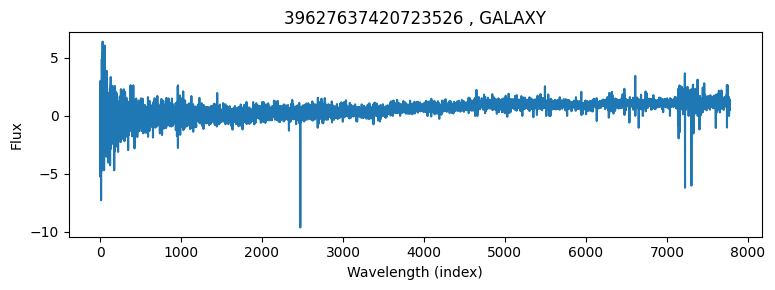

In [3]:
def get_spectype(tid):
    vals = df_spectra.loc[df_spectra['targetid'] == tid, 'spectype'].values
    return vals[0] if len(vals) > 0 else None

# Graficar
for i in range(min(10, len(targetids))):
    spectype = get_spectype(targetids[i])
    plt.figure(figsize=(8,3))
    plt.plot(flux_arrays[i])
    plt.title(f'{targetids[i]} , {spectype}')
    plt.xlabel('Wavelength (index)')
    plt.ylabel('Flux')
    plt.tight_layout()
    plt.show()


In [4]:
#construir matrices y normlizamos
label_map = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}
inv_label_map = {v: k for k, v in label_map.items()}

X_list, Y_list, TID_list = [], [], []

max_n = len(targetids)
for i in range(max_n):
    tid = targetids[i]
    spectype = get_spectype(tid)
    if spectype in label_map:
        X_list.append(flux_arrays[i])
        Y_list.append(label_map[spectype])
        TID_list.append(tid)

X = np.asarray(X_list, dtype=np.float32)
Y = np.asarray(Y_list, dtype=np.int64)
TID = np.asarray(TID_list)

print("X shape:", X.shape, "Y shape:", Y.shape)
classes, counts = np.unique(Y, return_counts=True)
print("Distribución inicial:", dict(zip([inv_label_map[c] for c in classes], counts)))

qso_mask = (Y == label_map['QSO'])
order = np.concatenate([np.where(qso_mask)[0], np.where(~qso_mask)[0]])
X = X[order]
Y = Y[order]
TID = TID[order]

# Normalización
def zscore_per_spectrum(Xarr, eps=1e-8):
    mu = Xarr.mean(axis=1, keepdims=True)
    sd = Xarr.std(axis=1, keepdims=True)
    return (Xarr - mu) / (sd + eps)

X = zscore_per_spectrum(X)
print("Normalización por z-score.")


X shape: (492, 7781) Y shape: (492,)
Distribución inicial: {'GALAXY': np.int64(326), 'STAR': np.int64(100), 'QSO': np.int64(66)}
Normalización por z-score.


In [5]:
def augment_spectra(
    X, Y, n_aug_per_sample=1, noise_std=0.02,
    jitter_max=1, scale_min=0.97, scale_max=1.03, seed=SEED
):
    rng = np.random.default_rng(seed)
    N, L = X.shape
    X_aug = []
    Y_aug = []
    for i in range(N):
        base = X[i]
        for _ in range(n_aug_per_sample):

            scale = rng.uniform(scale_min, scale_max)
            aug = base * scale

            shift = rng.integers(-jitter_max, jitter_max + 1)
            if shift != 0:
                aug = np.roll(aug, shift)

            aug = aug + rng.normal(0.0, noise_std, size=L)
            X_aug.append(aug.astype(np.float32))
            Y_aug.append(Y[i])
    return np.asarray(X_aug, dtype=np.float32), np.asarray(Y_aug, dtype=Y.dtype)

#entrenar con el 20% de los datos
X_train, X_test, y_train, y_test, tid_train, tid_test = train_test_split(
    X, Y, TID,
    test_size=0.20,
    random_state=SEED,
    stratify=Y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

qso_train_mask = (y_train == label_map['QSO'])
X_qso = X_train[qso_train_mask]
y_qso = y_train[qso_train_mask]

if len(X_qso) > 0:
    X_qso_aug, y_qso_aug = augment_spectra(X_qso, y_qso, n_aug_per_sample=1, noise_std=0.02, jitter_max=1)
    X_train = np.vstack([X_train, X_qso_aug])
    y_train = np.concatenate([y_train, y_qso_aug])

print("Train (tras refuerzo QSO):", X_train.shape)
print("Distribución train:", dict(zip(*np.unique(y_train, return_counts=True))))


Train: (393, 7781) Test: (99, 7781)
Train (tras refuerzo QSO): (446, 7781)
Distribución train: {np.int64(0): np.int64(260), np.int64(1): np.int64(80), np.int64(2): np.int64(106)}


input_dim: 7781 | num_classes: 3
Train Keras: (446, 7781) Test Keras: (99, 7781)


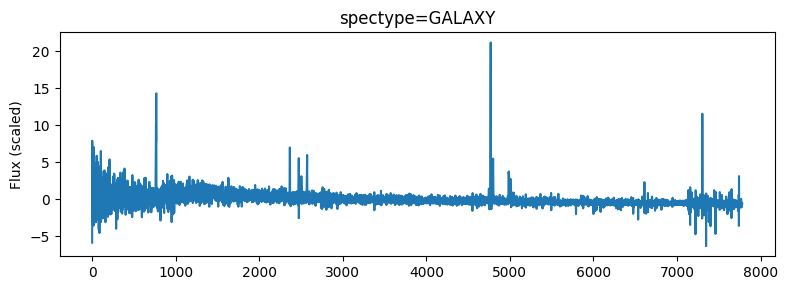

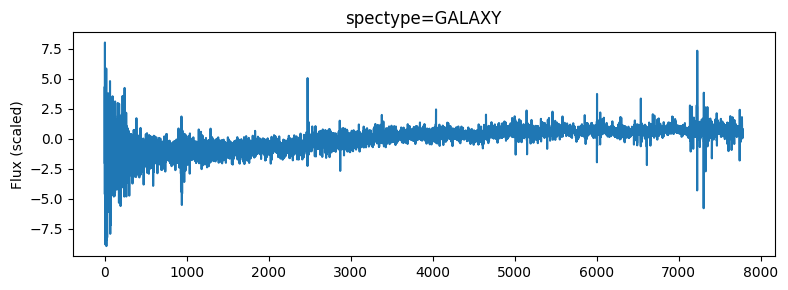

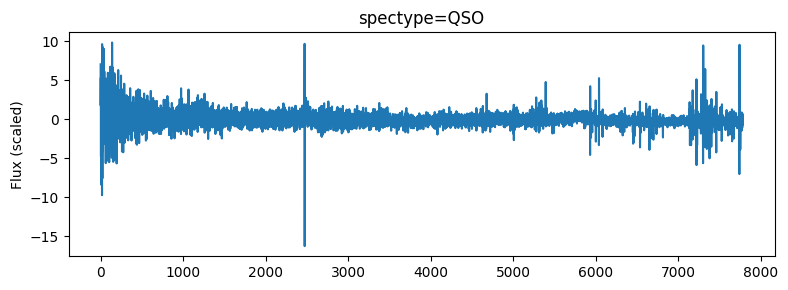

In [6]:
original_shape = X_train.shape[1:]  # (L,)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_test_scaled_flat  = scaler.transform(X_test_flat)

X_train_keras = X_train_scaled_flat.astype("float32")
X_test_keras  = X_test_scaled_flat.astype("float32")

y_train_keras = y_train
y_test_keras  = y_test

input_dim = X_train_keras.shape[1]
num_classes = len(np.unique(Y))

print("input_dim:", input_dim, "| num_classes:", num_classes)
print("Train Keras:", X_train_keras.shape, "Test Keras:", X_test_keras.shape)

#graficamos
for i in range(3):
    plt.figure(figsize=(8,3))
    plt.plot(X_train[i].ravel())
    plt.title(f'spectype={inv_label_map[y_train[i]]}')
    plt.ylabel('Flux (scaled)')
    plt.tight_layout()
    plt.show()


In [7]:
#creamos el modelo

def create_model():
    """
    Modelo sencillo: 1 capa oculta de 100 neuronas.
    Y de salida, num_classes neuronas con softmax.
    """
    model = keras.models.Sequential()
    model.add(layers.Dense(
        units=100,
        activation="relu",
        input_shape=(input_dim,)
    ))
    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

tf.random.set_seed(SEED)
np.random.seed(SEED)

clf = KerasClassifier(
    model=create_model,
    verbose=0,
    random_state=SEED
)

print("KerasClassifier (create_model) listo.")


KerasClassifier (create_model) listo.



===== Iniciando GridSearchCV (Grid 1: epochs, batch_size) =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



>>> Mejores hiperparámetros encontrados (Grid 1):
{'batch_size': 64, 'epochs': 10}
Mejor F1 (cross-validation): 0.8511078678817134

F1 (weighted) en test - mejor modelo Grid 1: 0.9013322923274614

Reporte de clasificación (red densa Keras - Grid 1):
               precision    recall  f1-score   support

      GALAXY       0.98      0.88      0.93        66
        STAR       0.77      1.00      0.87        20
         QSO       0.79      0.85      0.81        13

    accuracy                           0.90        99
   macro avg       0.85      0.91      0.87        99
weighted avg       0.91      0.90      0.90        99



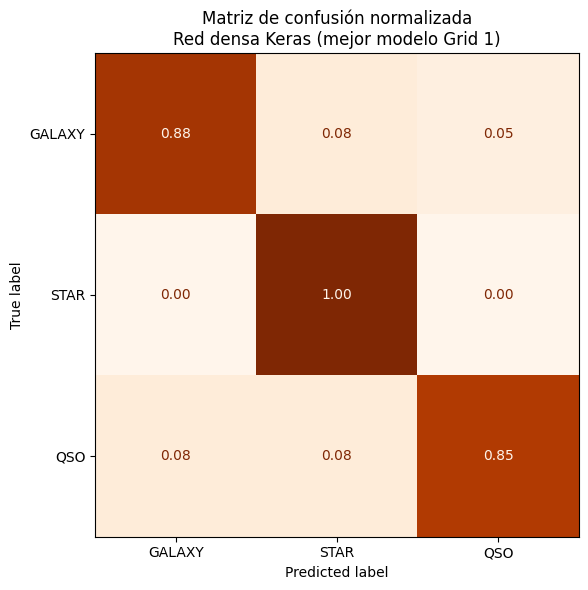

In [8]:
param_grid_1 = {
    "epochs": [5, 10],
    "batch_size": [32, 64]
}

grid_1 = GridSearchCV(
    estimator=clf,
    param_grid=param_grid_1,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\n===== Iniciando GridSearchCV (Grid 1: epochs, batch_size) =====")
grid_result_1 = grid_1.fit(X_train_keras, y_train_keras)

print("\n>>> Mejores hiperparámetros encontrados (Grid 1):")
print(grid_result_1.best_params_)
print("Mejor F1 (cross-validation):", grid_result_1.best_score_)

best_clf_1 = grid_result_1.best_estimator_
y_pred_1 = best_clf_1.predict(X_test_keras)

f1_test_1 = f1_score(y_test_keras, y_pred_1, average="weighted")
print("\nF1 (weighted) en test - mejor modelo Grid 1:", f1_test_1)

print("\nReporte de clasificación (red densa Keras - Grid 1):\n",
      classification_report(
          y_test_keras,
          y_pred_1,
          target_names=[inv_label_map[i] for i in range(num_classes)]
      ))

cm_dense_1 = confusion_matrix(y_test_keras, y_pred_1, normalize="true")
disp_dense_1 = ConfusionMatrixDisplay(confusion_matrix=cm_dense_1,
                                      display_labels=[inv_label_map[i] for i in range(num_classes)])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
disp_dense_1.plot(ax=ax, cmap="Oranges", values_format=".2f", colorbar=False)
plt.title("Matriz de confusión normalizada\nRed densa Keras (mejor modelo Grid 1)")
plt.tight_layout()
plt.show()


In [13]:
def create_model_2(neurons=100):

    tf.random.set_seed(SEED)
    np.random.seed(SEED)

    model = keras.models.Sequential()
    model.add(layers.Dense(
        units=neurons,
        activation="relu",
        input_shape=(input_dim,)
    ))
    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

clf2 = KerasClassifier(
    model=create_model_2,
    verbose=0,
    random_state=SEED
)

print("KerasClassifier (create_model_2) listo.")


KerasClassifier (create_model_2) listo.



===== Iniciando GridSearchCV (Grid 2: model__neurons) =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



>>> Mejores hiperparámetros encontrados (Grid 2):
{'batch_size': 32, 'epochs': 10, 'model__neurons': 64}
Mejor F1 (cross-validation): 0.8431200256960328

F1 (weighted) en test - mejor modelo Grid 2: 0.8783744222368773

Reporte de clasificación (red densa Keras optimizada - Grid 2):
               precision    recall  f1-score   support

      GALAXY       0.98      0.83      0.90        66
        STAR       0.90      0.95      0.93        20
         QSO       0.55      0.92      0.69        13

    accuracy                           0.87        99
   macro avg       0.81      0.90      0.84        99
weighted avg       0.91      0.87      0.88        99



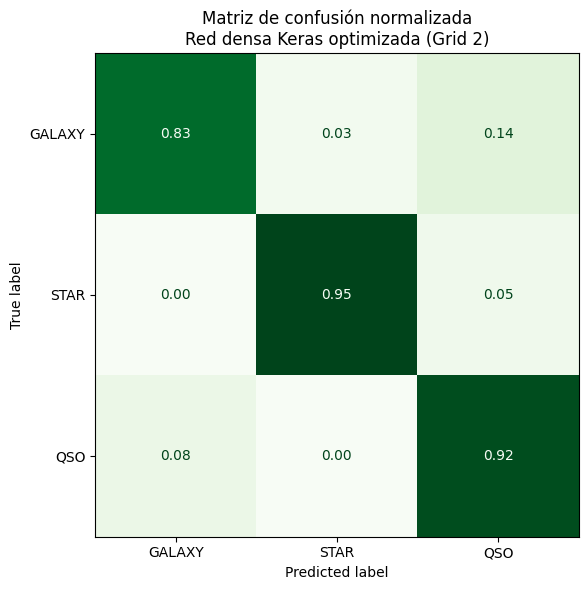

In [14]:
param_grid_2 = {
    "model__neurons": [64, 128, 256],
    "epochs": [10],
    "batch_size": [32]
}

grid_2 = GridSearchCV(
    estimator=clf2,
    param_grid=param_grid_2,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\n===== Iniciando GridSearchCV (Grid 2: model__neurons) =====")
grid_result_2 = grid_2.fit(X_train_keras, y_train_keras)

print("\n>>> Mejores hiperparámetros encontrados (Grid 2):")
print(grid_result_2.best_params_)
print("Mejor F1 (cross-validation):", grid_result_2.best_score_)

best_clf_2 = grid_result_2.best_estimator_
y_pred_2 = best_clf_2.predict(X_test_keras)

f1_test_2 = f1_score(y_test_keras, y_pred_2, average="weighted")
print("\nF1 (weighted) en test - mejor modelo Grid 2:", f1_test_2)

print("\nReporte de clasificación (red densa Keras optimizada - Grid 2):\n",
      classification_report(
          y_test_keras,
          y_pred_2,
          target_names=[inv_label_map[i] for i in range(num_classes)]
      ))

cm_dense_2 = confusion_matrix(y_test_keras, y_pred_2, normalize="true")
disp_dense_2 = ConfusionMatrixDisplay(confusion_matrix=cm_dense_2,
                                      display_labels=[inv_label_map[i] for i in range(num_classes)])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
disp_dense_2.plot(ax=ax, cmap="Greens", values_format=".2f", colorbar=False)
plt.title("Matriz de confusión normalizada\nRed densa Keras optimizada (Grid 2)")
plt.tight_layout()
plt.show()
